## <div align="center"> EfficientNetB3 - Image Classification </div>
***

This notebook aims to show how to implement EfficientNetB3 Deep Learning model for Stanford Dogs image classification. 

Sections:<a id='sections_b3'></a>

1. [Environment Setup](#environment_setup_b3) (incl. import libraries, load and prepare datasets)

2. [Model Implementation](#model_implementation_b3) (incl. setup, train and evaluate model.) 

3. [Wrap Up:](#wrap_up_b3) Discussion & Closing

<br>
NOTE: This notebook is one of the Computer Vision (CV) notebooks, which is designed to focus on Deep Learning models that use in CV areas (e.g. image classification, object detection, object tracking, semantic segmentation, instance segmentation and etc.). Do consider other notebooks if looking for different Deep Learning models approach or examples. 
<br>
<br>

### 1. Environment Setup <a id='environment_setup_b3'></a> 

[Sections](#sections_b3)

In [1]:
# import libraries
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn')
sns.set(style="whitegrid")

import warnings
warnings.filterwarnings("ignore")

In [2]:
# define parameters & load Data

batch_size = 64
IMG_SIZE = 300

dataset_name = "stanford_dogs"
(ds_train, ds_test), ds_info = tfds.load(dataset_name, split=["train", "test"], with_info=True, as_supervised=True)
NUM_CLASSES = ds_info.features["label"].num_classes

size = (IMG_SIZE, IMG_SIZE)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))

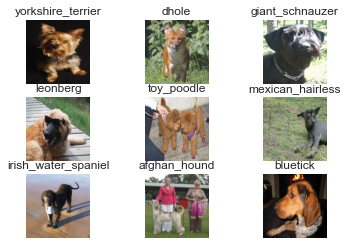

In [3]:
# viz dataset
def format_label(label):
    string_label = label_info.int2str(label)
    return string_label.split("-")[1]


label_info = ds_info.features["label"]
for i, (image, label) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title("{}".format(format_label(label)))
    plt.axis("off")

In [4]:
# clean & prepare data

# One-hot / categorical encoding
def input_preprocess(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


ds_train = ds_train.map(input_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.batch(batch_size=batch_size, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

ds_test = ds_test.map(input_preprocess)
ds_test = ds_test.batch(batch_size=batch_size, drop_remainder=True)

### 2. Model Implementation <a id='model_implementation_b3'></a>

[Sections](#sections_b3)

In [5]:
# initiate model 
model = tf.keras.models.Sequential()

# build model
model.add(tf.keras.applications.EfficientNetB3(input_shape = (IMG_SIZE, IMG_SIZE, 3), include_top = False, weights = 'imagenet')) # load pre-trained weights
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation = 'relu', bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001)))
model.add(tf.keras.layers.Dropout(0.7))
model.add(tf.keras.layers.Dense(32, activation = 'relu', bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001)))
model.add(tf.keras.layers.Dropout(0.7))
model.add(tf.keras.layers.Dense(NUM_CLASSES, activation = 'softmax'))

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# check model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 10, 10, 1536)      10783535  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               393472    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                8224      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0

In [6]:
# fit model
history = model.fit(ds_train, validation_data = ds_test, steps_per_epoch = 20, epochs = 5)

Epoch 1/5
20/20 [==============================] - 1623s 83s/step - loss: 4.8474 - accuracy: 0.0141 - val_loss: 4.7523 - val_accuracy: 0.0246
Epoch 2/5
20/20 [==============================] - 1524s 78s/step - loss: 4.8165 - accuracy: 0.0117 - val_loss: 4.7740 - val_accuracy: 0.0168
Epoch 3/5
20/20 [==============================] - 1559s 80s/step - loss: 4.7967 - accuracy: 0.0125 - val_loss: 4.7834 - val_accuracy: 0.0107
Epoch 4/5
20/20 [==============================] - 1578s 81s/step - loss: 4.7906 - accuracy: 0.0109 - val_loss: 4.7868 - val_accuracy: 0.0114
Epoch 5/5
20/20 [==============================] - 1587s 81s/step - loss: 4.8201 - accuracy: 0.0078 - val_loss: 4.7861 - val_accuracy: 0.0105


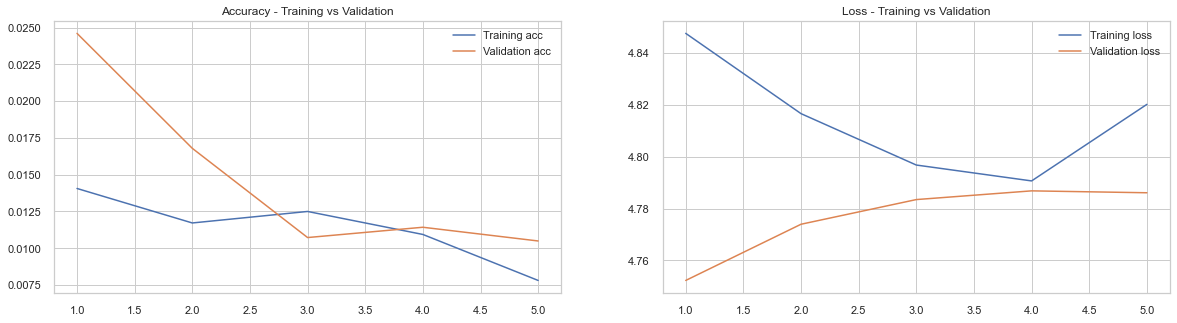

In [7]:
# check train and validation: loss & accuacy
sns.set(style="whitegrid")

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
sns.lineplot(ax=ax[0], x=epochs, y=acc, label='Training acc')
sns.lineplot(ax=ax[0], x=epochs, y=val_acc, label='Validation acc')
ax[0].set_title("Accuracy - Training vs Validation")

sns.lineplot(ax=ax[1], x=epochs, y=loss, label='Training loss')
sns.lineplot(ax=ax[1], x=epochs, y=val_loss, label='Validation loss')
ax[1].set_title("Loss - Training vs Validation");

In [8]:
# evaluate model
scores = model.evaluate(ds_test, verbose=1)
print("test loss: ", scores[0])
print("test acc: ", scores[1])

134/134 [==============================] - 676s 5s/step - loss: 4.7861 - accuracy: 0.0105
test loss:  4.786067485809326
test acc:  0.01049440260976553


### 3. Wrap Up <a id='wrap_up_b3'></a>

[Sections](#sections_b3)

**Discussion & Closing:**

One of the points that is worth mentioning is Transfer Learning (TL), which is widely used in nearly all CV problems. TL is the idea of leveraging a pre-trained model (eps. weights) for a new problem without training the model from scatrch. This idea is particularly useful when solving complex problems for many reasons. Apart from overcoming the issue of insufficient dataset, TL also helps speeding up the deployment of any real-world applications without forgoing too much cost. For these reasons, many new domains with little knowledge and limited resources (e.g. skilled domain experts, a massive supporting dataset, powerful technologies) could now make use of Deep Learning models. For instance, this example has leveraged on the pre-trained models for different uses, thanks to the people who make the tools available for everyone.

To wrap up, the objective of this notebook is to show how EfficientNetB3 Deep Learning model is used for Stanford Dogs image classification.